### Import

In [1]:
import pandas as pd
import numpy as np
import sys
import glob

In [2]:
sys.path.insert(0, '../code/')

In [3]:
from loading_routines import *
from preprocessing import *
from feature_engineering import *
from mov_ampl import *

### Load data

In [4]:
all_files = glob.glob('../data/behavior_AND_personality_dataset/joints/*.xml')
#print all_files
all_files_new = glob.glob('../data/data_recordings_master/joints/*.xml')

In [5]:
all_subjects_dfs = [load_df_from_xml(f) for f in all_files[:2]+all_files_new[:2]]

Loaded 0 tracks for "subject6"
Loaded 1000 tracks for "subject6"
Loaded 2000 tracks for "subject6"
Loaded 3000 tracks for "subject6"
Loaded 4000 tracks for "subject6"
Loaded 5000 tracks for "subject6"
Loaded 6000 tracks for "subject6"
Loaded 7000 tracks for "subject6"
Loaded 8000 tracks for "subject6"
Loaded 9000 tracks for "subject6"
Loaded 10000 tracks for "subject6"
Loaded 11000 tracks for "subject6"
Loaded 12000 tracks for "subject6"
Loaded 13000 tracks for "subject6"
Loaded 14000 tracks for "subject6"
Loaded 15000 tracks for "subject6"
Loaded 16000 tracks for "subject6"
Loaded 17000 tracks for "subject6"
Loaded 18000 tracks for "subject6"
Loaded 19000 tracks for "subject6"
Loaded 20000 tracks for "subject6"
Loaded 21000 tracks for "subject6"
Loaded 22000 tracks for "subject6"
Loaded 23000 tracks for "subject6"
Loaded 24000 tracks for "subject6"
Loaded 25000 tracks for "subject6"
Loaded 26000 tracks for "subject6"
Loaded 27000 tracks for "subject6"
Loaded 0 tracks for "subject11"
L

## Preprocessing

#### Remove outliers

In [6]:
dfs_prep = [remove_outliers(df, low_percentil=0.05, high_percentil=0.95) for df in all_subjects_dfs]

In [7]:
df_prep_norm = [normalize_data(df) for df in dfs_prep]

#### Normalization

In [8]:
df_prep_norm[0].head()

,subject,frameId,time,trackingId,head_x,head_y,head_z,neck_x,neck_y,neck_z,...,kneeL_x,kneeL_y,kneeL_z,ankleL_x,ankleL_y,ankleL_z,footL_x,footL_y,footL_z,task
0,subject6,991,Wed Oct 19 15:55:24 2016,72057594037947129,0.193488,0.050442,0.159526,0.186517,0.083324,0.116526,...,0.175540,0.711118,0.277174,0.189702,0.923704,0.085580,0.202934,0.962237,0.098948,0
1,subject6,992,Wed Oct 19 15:55:24 2016,72057594037947129,0.187270,0.050717,0.167793,0.177438,0.080450,0.131941,...,0.172710,0.710391,0.286718,0.152952,0.853278,0.105883,0.169204,0.870257,0.169099,0
2,subject6,993,Wed Oct 19 15:55:24 2016,72057594037947129,0.177900,0.051404,0.181039,0.170087,0.076341,0.144114,...,0.169484,0.711853,0.281418,0.111479,0.848848,0.134538,0.141249,0.845328,0.209495,0
3,subject6,994,Wed Oct 19 15:55:24 2016,72057594037947129,0.169478,0.047516,0.190497,0.162171,0.072511,0.155078,...,0.076380,0.656198,0.200410,0.020710,0.705735,0.143842,0.073969,0.726426,0.192053,0
4,subject6,995,Wed Oct 19 15:55:24 2016,72057594037947129,0.154343,0.057471,0.207117,0.153885,0.073859,0.167286,...,0.058911,0.653148,0.210872,0.068977,0.806063,0.227709,0.123251,0.807287,0.284098,0


#### Detect frames with little movement

* either of the head coordinates in a sequence moves more than 0.03

In [9]:
#is a list of lists
# "little movement" not little enough?
dfs_little_movement = [get_sequences_with_little_movement(df, variables_to_check=['head_x', 'head_y', 'head_z'], max_mov=0.03) for df in df_prep_norm]

In [10]:
for df in dfs_little_movement:
    print 'Length of sequences with little movement for ', df[0]['subject'].iloc[0]
    print '*'*5
    for d in df:
        print(len(d))

Length of sequences with little movement for  subject6
*****
83
77
93
154
158
61
155
729
77
71
337
109
73
110
366
75
193
298
202
361
301
331
431
Length of sequences with little movement for  subject11
*****
60
114
77
976
453
806
128
96
192
1473
121
72
179
1108
79
111
90
194
70
62
189
81
Length of sequences with little movement for  subject35
*****
77
198
140
62
78
104
209
77
98
79
184
120
92
73
68
93
198
75
79
87
238
156
968
75
1314
655
106
228
80
123
196
86
116
71
75
Length of sequences with little movement for  subject50
*****
63
77
64
61
107
168
440
111
285
64
202
66
70
61
141
85
92
73
86


In [11]:
#dfs_little_movement[-1][-1]

In [12]:
dfs_little_movement[0][0].head()

,subject,frameId,time,trackingId,head_x,head_y,head_z,neck_x,neck_y,neck_z,...,kneeL_x,kneeL_y,kneeL_z,ankleL_x,ankleL_y,ankleL_z,footL_x,footL_y,footL_z,task
1695,subject6,9303,Wed Oct 19 16:00:03 2016,72057594037947205,0.495971,0.058923,0.242586,0.490879,0.093694,0.187847,...,0.392288,0.823214,0.170114,0.349299,0.889601,0.142171,0.370626,0.938303,0.098087,2
1696,subject6,9304,Wed Oct 19 16:00:03 2016,72057594037947205,0.495200,0.058205,0.242397,0.490727,0.092947,0.187473,...,0.392290,0.823378,0.170191,0.349286,0.890661,0.142751,0.370430,0.939380,0.098622,2
1697,subject6,9305,Wed Oct 19 16:00:03 2016,72057594037947205,0.494351,0.056814,0.242120,0.490748,0.091351,0.187304,...,0.392316,0.823389,0.170237,0.349440,0.890883,0.142208,0.370342,0.939696,0.097997,2
1698,subject6,9306,Wed Oct 19 16:00:03 2016,72057594037947205,0.492720,0.057183,0.239010,0.490591,0.090622,0.187200,...,0.392326,0.823388,0.170231,0.349649,0.890323,0.141886,0.370583,0.939149,0.097682,2
1699,subject6,9307,Wed Oct 19 16:00:03 2016,72057594037947205,0.492612,0.057803,0.239045,0.490505,0.091326,0.187034,...,0.392372,0.823273,0.170216,0.349649,0.890563,0.141944,0.370789,0.939321,0.097798,2


In [13]:
all_little_movement_per_person = [pd.concat(df) for df in dfs_little_movement]

In [14]:
for df in all_little_movement_per_person:
    print len(df)

4845
6731
6678
2316


### Extract Posture Features for upper joints

In [15]:
upper_joints = ['head_x', 'head_y', 'head_z',
              'neck_x', 'neck_y', 'neck_z',
              'spineShoulder_x', 'spineShoulder_y', 'spineShoulder_z',
              'shoulderR_x', 'shoulderR_y', 'shoulderR_z',
              'elbowR_x', 'elbowR_y', 'elbowR_z',
              'wristR_x', 'wristR_y', 'wristR_z',
              'handR_x', 'handR_y', 'handR_z',
              'shoulderL_x', 'shoulderL_y', 'shoulderL_z',
              'elbowL_x', 'elbowL_y', 'elbowL_z',
              'wristL_x', 'wristL_y', 'wristL_z',
              'handL_x', 'handL_y', 'handL_z']

In [16]:
posture_per_person = [calculate_joint_differences(df, only_for_columns=upper_joints) for df in all_little_movement_per_person]

In [17]:
print 'Total posture features: ', len(posture_per_person[0].columns)

Total posture features:  165


In [18]:
posture_per_person[0].head()

,elbowL_x-elbowR_x,elbowL_x-handL_x,elbowL_y-handL_y,elbowL_z-elbowR_z,elbowL_z-handL_z,elbowL_z-wristL_z,elbowR_x-handL_x,elbowR_y-elbowL_y,elbowR_y-handL_y,elbowR_z-handL_z,...,wristR_y-elbowL_y,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z
1695,-0.071351,-0.006759,-0.091727,0.0,-0.157180,-0.108825,0.064591,0.0,-0.091727,-0.157180,...,0.135032,0.135032,0.043305,0.329281,0.033023,-0.067589,-0.067589,-0.224768,-0.044999,-0.176413
1696,-0.070668,-0.005767,-0.092949,0.0,-0.159149,-0.111614,0.064901,0.0,-0.092949,-0.159149,...,0.135162,0.135162,0.042212,0.332272,0.037083,-0.067668,-0.067668,-0.226817,-0.046047,-0.179282
1697,-0.069865,0.000708,-0.071139,0.0,-0.192166,-0.113818,0.070573,0.0,-0.071139,-0.192166,...,0.135209,0.135209,0.064070,0.335350,0.039276,-0.067709,-0.067709,-0.259875,-0.046281,-0.181528
1698,-0.069072,0.000729,-0.065214,0.0,-0.191996,-0.113539,0.069800,0.0,-0.065214,-0.191996,...,0.135240,0.135240,0.070026,0.336703,0.045564,-0.067730,-0.067730,-0.259726,-0.046229,-0.181269
1699,-0.068773,0.000727,-0.066591,0.0,-0.192605,-0.114133,0.069500,0.0,-0.066591,-0.192605,...,0.135359,0.135359,0.068768,0.335621,0.044156,-0.067756,-0.067756,-0.260360,-0.046283,-0.181889


In [24]:
posture_per_person[3].columns[96]

'shoulderR_x-wristL_x'

In [25]:
mean_posture_features = []
for i, df in enumerate(posture_per_person):
    pos_mean = pd.DataFrame([df.mean().values], columns=df.mean().index)
    subject = all_little_movement_per_person[i].iloc[0]['subject']
    pos_mean['subject'] = subject
    mean_posture_features.append(pos_mean)

In [26]:
mean_posture_features[0]

,elbowL_x-elbowR_x,elbowL_x-handL_x,elbowL_y-handL_y,elbowL_z-elbowR_z,elbowL_z-handL_z,elbowL_z-wristL_z,elbowR_x-handL_x,elbowR_y-elbowL_y,elbowR_y-handL_y,elbowR_z-handL_z,...,wristR_y-elbowR_y,wristR_y-handL_y,wristR_y-neck_y,wristR_y-wristL_y,wristR_z-elbowL_z,wristR_z-elbowR_z,wristR_z-handL_z,wristR_z-neck_z,wristR_z-wristL_z,subject
0,-0.020189,-0.061946,0.044383,0.0,0.103449,0.081981,-0.041757,0.0,0.044383,0.103449,...,-0.054714,-0.010331,-0.128033,0.005468,-0.076898,-0.076898,0.02655,-0.089754,0.005082,subject6


In [27]:
posture_feat_df = pd.concat(mean_posture_features)

In [28]:
posture_feat_df.columns[96]

'shoulderR_x-wristL_x'

#### Look at specific set of posture features


In [22]:
specific_posture = ['head_'+coord+'-shoulderL_'+coord for coord in ['x', 'y', 'z']]+['shoulderR_'+coord+'-head_'+coord for coord in ['x', 'y', 'z']]+['shoulderR_'+coord+'-shoulderL_'+coord for coord in ['x', 'y', 'z']]+['wristR_'+coord+'-neck_'+coord for coord in ['x', 'y', 'z']]
specific_posture

['head_x-shoulderL_x',
 'head_y-shoulderL_y',
 'head_z-shoulderL_z',
 'shoulderR_x-head_x',
 'shoulderR_y-head_y',
 'shoulderR_z-head_z',
 'shoulderR_x-shoulderL_x',
 'shoulderR_y-shoulderL_y',
 'shoulderR_z-shoulderL_z',
 'wristR_x-neck_x',
 'wristR_y-neck_y',
 'wristR_z-neck_z']

In [23]:
#get subject number back (was lost while calculating posture features)
for i, df in enumerate(posture_per_person):
    subject = all_little_movement_per_person[i].iloc[0]['subject']
    df['subject'] = [subject]*len(df)

In [24]:
for df in posture_per_person:
    print'Means for subject ', df['subject'].iloc[0]
    print '*'*5
    print df[specific_posture].mean()

Means for subject  subject6
*****
head_x-shoulderL_x         0.024852
head_y-shoulderL_y         0.035255
head_z-shoulderL_z         0.013960
shoulderR_x-head_x        -0.020089
shoulderR_y-head_y        -0.026990
shoulderR_z-head_z         0.007576
shoulderR_x-shoulderL_x    0.004763
shoulderR_y-shoulderL_y    0.008264
shoulderR_z-shoulderL_z    0.021536
wristR_x-neck_x            0.026861
wristR_y-neck_y           -0.128033
wristR_z-neck_z           -0.089754
dtype: float64
Means for subject  subject11
*****
head_x-shoulderL_x         0.046535
head_y-shoulderL_y         0.026300
head_z-shoulderL_z        -0.046023
shoulderR_x-head_x        -0.019073
shoulderR_y-head_y        -0.008002
shoulderR_z-head_z         0.041415
shoulderR_x-shoulderL_x    0.027462
shoulderR_y-shoulderL_y    0.018297
shoulderR_z-shoulderL_z   -0.004608
wristR_x-neck_x            0.027383
wristR_y-neck_y           -0.210175
wristR_z-neck_z           -0.056553
dtype: float64
Means for subject  subject9
*****
hea

In [25]:
import matplotlib.pyplot as plt
len(posture_per_person[0][specific_posture])

4845

In [26]:
big_posture_df = pd.concat(posture_per_person)
len(big_posture_df)

223975

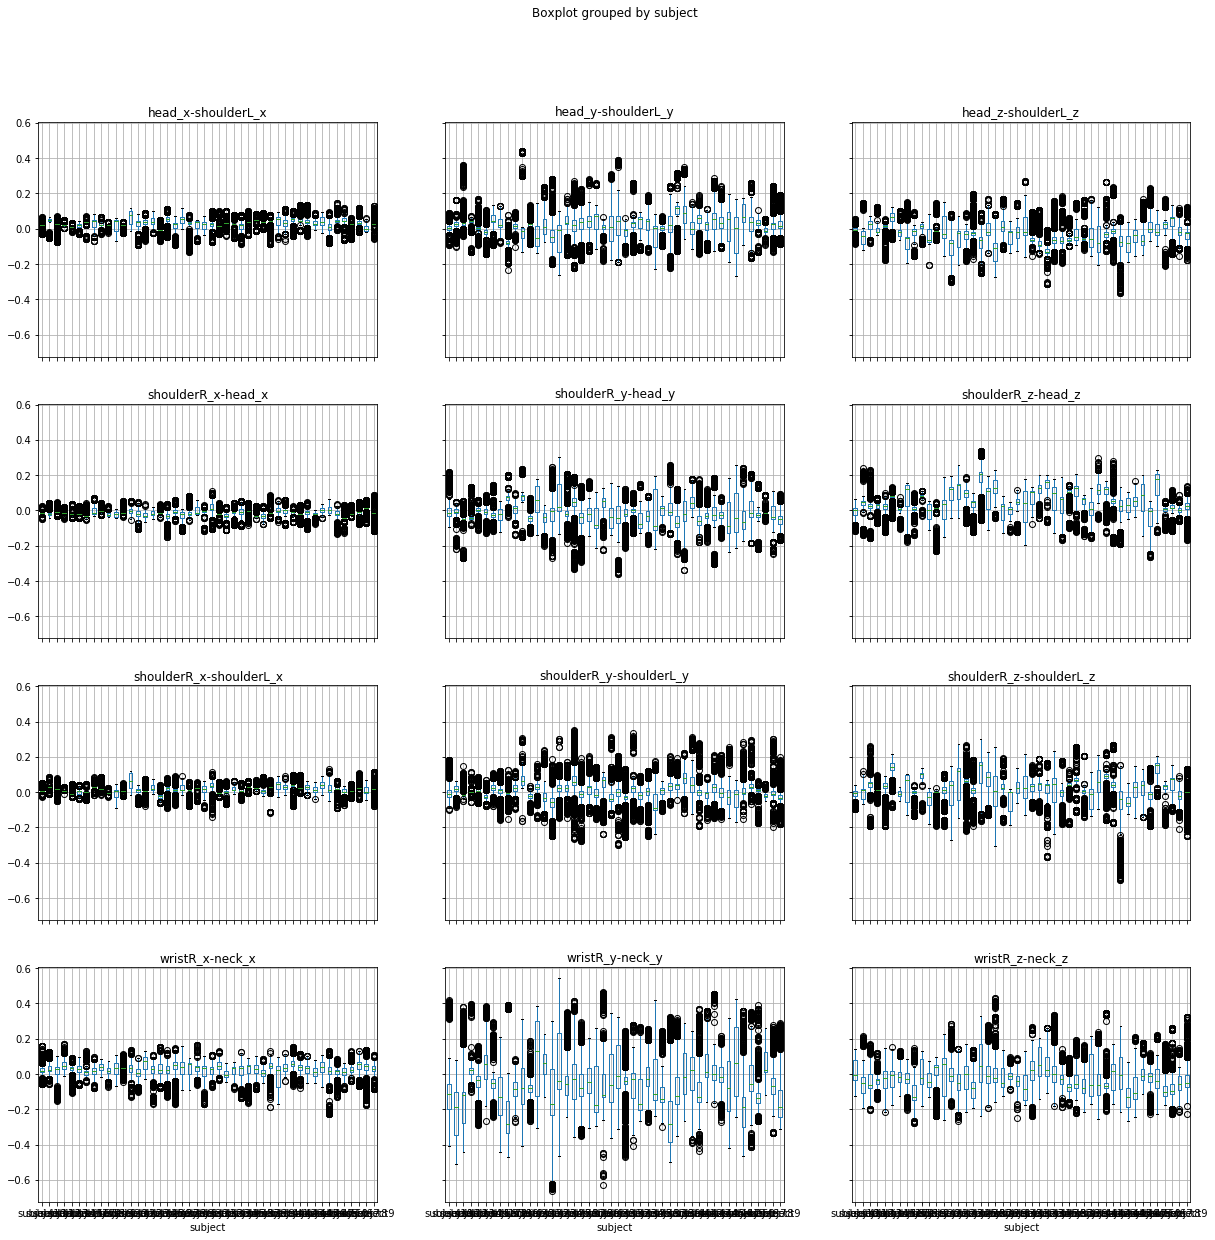

In [27]:
#fig=plt.figure(figsize=(20, 20))
big_posture_df.boxplot(column = specific_posture,
                       by='subject', figsize=(20,20))
plt.show()

## Extract Movement Amplitude features

In [28]:
amplitude_feature_dfs = []
still_joints = ['spineMid', 'neck']
mov_joints = ['handR', 'handL', 'wristL', 'head']
for df in all_subjects_dfs:
    subject = df['subject'].iloc[0]
    subject_amp_dfs = []
    for still in still_joints:
        for mov in mov_joints:            
            subject_amp_dfs.append(mov_amplitude(df, s_joint=still, m_joint=mov).reset_index())
    amp_df = pd.concat(subject_amp_dfs, axis=1)
    amp_df['subject'] = subject
    #print(amp_df)
    amplitude_feature_dfs.append(amp_df)

In [29]:
mov_amplitude(df, s_joint=still, m_joint=mov)

,ampl_freq_neck_x-head_x,ampl_freq_neck_y-head_y,ampl_freq_neck_z-head_z,ampl_max_neck_x-head_x,ampl_max_neck_y-head_y,ampl_max_neck_z-head_z,ampl_min_neck_x-head_x,ampl_min_neck_y-head_y,ampl_min_neck_z-head_z,ampl_mean_neck_x-head_x,ampl_mean_neck_y-head_y,ampl_mean_neck_z-head_z
neck-head,0.017691,0.004423,0.182663,0.058438,0.193604,0.060364,0.000003,0.000061,0.00001,0.014189,0.041352,0.022174


In [30]:
amplitude_df = pd.concat(amplitude_feature_dfs).reset_index()
amplitude_df.drop('index', axis=1, inplace=True)
amplitude_df.drop('level_0', axis=1, inplace=True)
amplitude_df.head()
#amplitude_df.join(mean_posture_features, on='subject')

,ampl_freq_spineMid_x-handR_x,ampl_freq_spineMid_y-handR_y,ampl_freq_spineMid_z-handR_z,ampl_max_spineMid_x-handR_x,ampl_max_spineMid_y-handR_y,ampl_max_spineMid_z-handR_z,ampl_min_spineMid_x-handR_x,ampl_min_spineMid_y-handR_y,ampl_min_spineMid_z-handR_z,ampl_mean_spineMid_x-handR_x,...,ampl_max_neck_x-head_x,ampl_max_neck_y-head_y,ampl_max_neck_z-head_z,ampl_min_neck_x-head_x,ampl_min_neck_y-head_y,ampl_min_neck_z-head_z,ampl_mean_neck_x-head_x,ampl_mean_neck_y-head_y,ampl_mean_neck_z-head_z,subject
0,0.117733,0.000969,0.005329,0.172667,0.713343,0.302261,0.000046,0.000047,0.000258,0.063233,...,0.051531,0.114169,0.109415,7.004004e-07,0.000005,0.000063,0.018224,0.031018,0.038273,subject6
1,0.035607,0.002574,0.030888,0.198132,0.496728,0.236194,0.000180,0.000004,0.000015,0.064803,...,0.059233,0.142932,0.057819,3.738658e-06,0.000008,0.000004,0.016672,0.025206,0.034897,subject11
2,0.036305,0.006454,0.121823,0.240200,0.429095,0.330418,0.000009,0.000022,0.000001,0.066815,...,0.070597,0.114212,0.070712,2.443859e-05,0.000011,0.000044,0.021058,0.026541,0.021455,subject9
3,0.046160,0.012336,0.029845,0.222391,0.334316,0.219836,0.000010,0.000082,0.000169,0.063715,...,0.053362,0.134203,0.062366,1.548227e-05,0.000171,0.000005,0.011899,0.038814,0.029251,subject8
4,0.042373,0.015890,0.005297,0.183111,0.398307,0.244505,0.000008,0.000046,0.000033,0.060927,...,0.057486,0.141016,0.083744,2.269376e-06,0.000010,0.000020,0.015949,0.031820,0.033701,subject4


In [31]:
all_features = amplitude_df.merge(posture_feat_df, on='subject')
all_features.loc[17, 'subject'] = 'subject17' #fix naming error
#all_features['subject']

### Sensor features

In [32]:
import sensor_data
import sensor_features

In [33]:
sensor_files1 = glob.glob('../data/behavior_AND_personality_dataset/binary/*.txt')
sensor_files2 = glob.glob('../data/data_recordings_master/binary/*.txt')
sensor_files1[1]

'../data/behavior_AND_personality_dataset/binary/18-10-16_sensors_subject14.txt'

In [34]:
#TODO: extract sensor features and concat to feature dataframe
sensor_features_files1 = sensor_features.extract_features(sensor_data.sensor_data_to_data_frame('../data/behavior_AND_personality_dataset/binary/*.txt'))
sensor_features_files2 = sensor_features.extract_features(sensor_data.sensor_data_to_data_frame('../data/data_recordings_master/binary/*.txt'))
df_sensor_features = sensor_features_files1.append(sensor_features_files2, ignore_index=True)

OSError: [Errno 2] No such file or directory: '../data/behavior_AND_personality_dataset/binary/*.txt'

### Speed features

In [35]:
import preprocessing
import speed_feature

In [36]:
#TODO: extract speed features and concat to feature
all_speed_features = [speed_feature.speed(df) for df in all_subjects_dfs]

../code/preprocessing.py:101: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()
  return pd.ewma(df, span=30)


In [37]:
speed_feature_df = pd.concat(all_speed_features)
all_features = all_features.merge(speed_feature_df, on='subject')

In [38]:
var_features = list(all_features.var().index[(all_features.var()>0.001).values])
var_features

['ampl_freq_spineMid_x-handR_x',
 'ampl_freq_spineMid_z-handR_z',
 'ampl_max_spineMid_y-handR_y',
 'ampl_max_spineMid_z-handR_z',
 'ampl_freq_spineMid_z-handL_z',
 'ampl_max_spineMid_y-handL_y',
 'ampl_max_spineMid_z-handL_z',
 'ampl_freq_spineMid_z-wristL_z',
 'ampl_max_spineMid_y-wristL_y',
 'ampl_max_spineMid_z-wristL_z',
 'ampl_freq_spineMid_x-head_x',
 'ampl_freq_spineMid_y-head_y',
 'ampl_freq_spineMid_z-head_z',
 'ampl_max_spineMid_y-head_y',
 'ampl_freq_neck_z-handR_z',
 'ampl_max_neck_y-handR_y',
 'ampl_max_neck_z-handR_z',
 'ampl_freq_neck_z-handL_z',
 'ampl_max_neck_x-handL_x',
 'ampl_max_neck_y-handL_y',
 'ampl_max_neck_z-handL_z',
 'ampl_freq_neck_z-wristL_z',
 'ampl_max_neck_x-wristL_x',
 'ampl_max_neck_y-wristL_y',
 'ampl_max_neck_z-wristL_z',
 'ampl_freq_neck_y-head_y',
 'ampl_freq_neck_z-head_z',
 'elbowL_y-handL_y',
 'elbowL_z-handL_z',
 'elbowL_z-wristL_z',
 'elbowR_y-handL_y',
 'elbowR_z-handL_z',
 'handR_y-elbowL_y',
 'handR_y-elbowR_y',
 'handR_y-handL_y',
 'handR

In [39]:
import seaborn as sns
%matplotlib inline

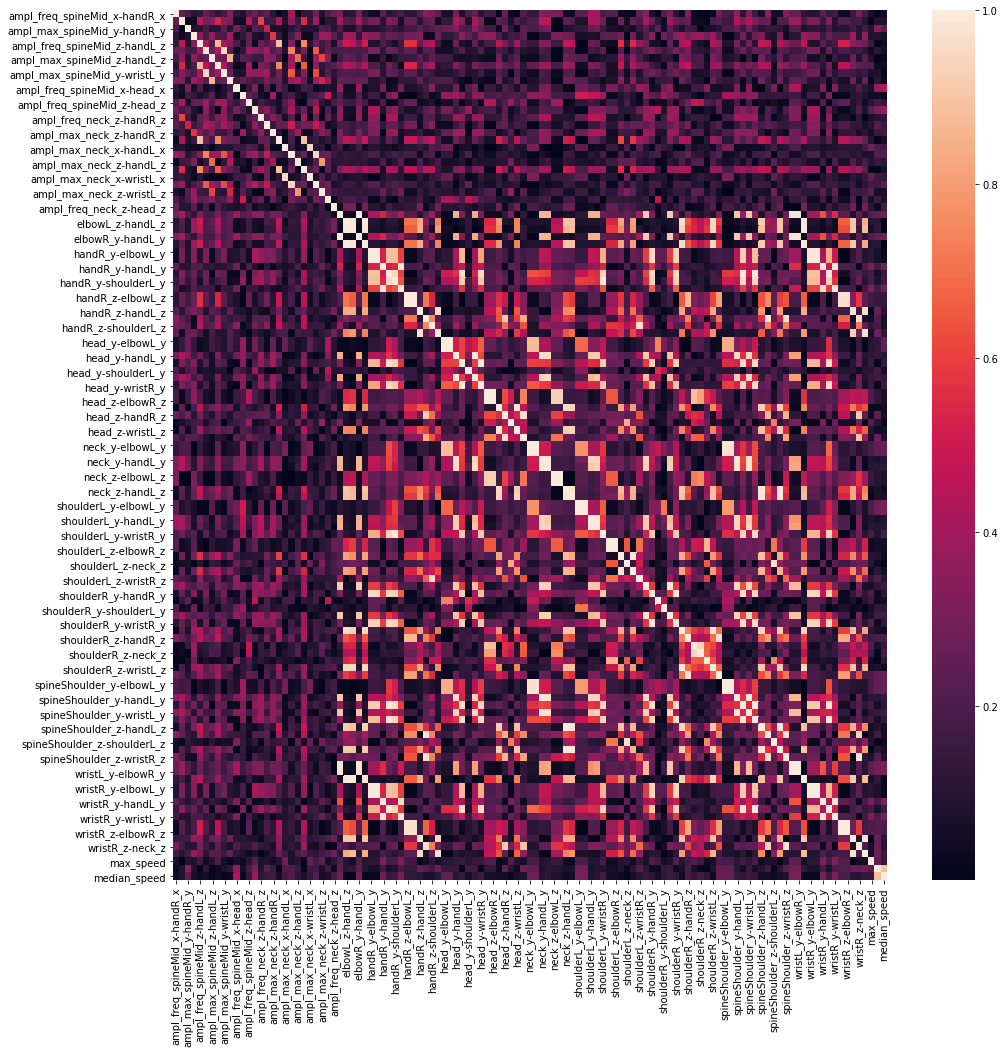

In [40]:
fig=plt.figure(figsize=(16, 16))
sns.heatmap(np.abs(all_features[var_features].corr()))

### Load personality data

In [41]:
import personality_data

In [42]:
personality_df = personality_data.personality_data_to_data_frame('../data/behavior_AND_personality_dataset/big5_personality_result.txt')
names = [s.replace('_', '') for s in personality_df['name']]
personality_df = personality_df.transpose()
#print(personality_df)
cols = personality_df.index[11:]
#print(cols)
personality_df = normalize_data(personality_df[11:], columns=personality_df.columns).transpose()
personality_df.columns = cols
personality_df['subject'] = names
personality_df.head()

,extraversion,agreeableness,conscientiousness,neuroticism,openness_to_experience,subject
0,0.333333,1.000000,0.666667,0.000000,1.00,subject2
1,0.000000,0.250000,1.000000,1.000000,0.25,subject3
2,0.000000,1.000000,0.000000,0.000000,0.00,subject4
3,0.000000,0.666667,0.666667,0.666667,1.00,subject5
4,0.000000,1.000000,1.000000,0.500000,0.00,subject6


In [43]:
with open('../data/data_recordings_master/personality.txt', 'r') as f:
    rows = [row.replace('\r', '').replace('\n', '').split() for row in f.readlines()]
#print(rows)
new_rows = []
for row in rows:
    new_row = []
    for v in row:
        if v.startswith('s'):
            new_row.append(v)
        else:
            new_row.append(int(v))
    new_rows.append(new_row)
            
columns = personality_data.get_column_names()[:11]
personality_df2 = pd.DataFrame(new_rows, columns=columns)
personality_df2.head()

,name,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10
0,subject_50,2,4,5,4,4,4,1,3,2,4
1,subject_21,2,4,3,4,1,5,1,3,3,4
2,subject_22,3,4,4,4,3,3,2,2,3,4
3,subject_23,4,3,2,5,4,5,2,4,1,4
4,subject_24,2,3,4,4,3,4,3,5,2,3


In [44]:
extraversion = 5 - personality_df2['question_1'].values + personality_df2['question_6'].values
agreeableness = personality_df2['question_2'].values+ (5-personality_df2['question_7'].values)
conscientiousness = 5-personality_df2['question_3'].values + personality_df2['question_8'].values
neuroticism = 5-personality_df2['question_4'].values + personality_df2['question_9'].values
openess = 5-personality_df2['question_5'].values+personality_df2['question_10'].values

In [45]:
personality_df2['extraversion'] = extraversion
personality_df2['agreeableness'] = agreeableness
personality_df2['conscientiousness'] = conscientiousness
personality_df2['neuroticism'] = neuroticism
personality_df2['openness_to_experience'] = openess
personality_df2.head()

,name,question_1,question_2,question_3,question_4,question_5,question_6,question_7,question_8,question_9,question_10,extraversion,agreeableness,conscientiousness,neuroticism,openness_to_experience
0,subject_50,2,4,5,4,4,4,1,3,2,4,7,8,3,3,5
1,subject_21,2,4,3,4,1,5,1,3,3,4,8,8,5,4,8
2,subject_22,3,4,4,4,3,3,2,2,3,4,5,7,3,4,6
3,subject_23,4,3,2,5,4,5,2,4,1,4,6,6,7,1,5
4,subject_24,2,3,4,4,3,4,3,5,2,3,7,5,6,3,5


In [46]:
names = [s.replace('_', '') for s in personality_df2['name']]
personality_df2 = personality_df2.transpose()
#print(personality_df)
cols = personality_df2.index[11:]
#print(cols)
personality_df2 = normalize_data(personality_df2[11:], columns=personality_df2.columns).transpose()
personality_df2.columns = cols
personality_df2['subject'] = names
personality_df2.head()

,extraversion,agreeableness,conscientiousness,neuroticism,openness_to_experience,subject
0,0.800000,1.000000,0.00,0.00,0.400000,subject50
1,1.000000,1.000000,0.25,0.00,1.000000,subject21
2,0.500000,1.000000,0.00,0.25,0.750000,subject22
3,0.833333,0.833333,1.00,0.00,0.666667,subject23
4,1.000000,0.500000,0.75,0.00,0.500000,subject24


In [47]:
personality_full = pd.concat([personality_df, personality_df2], axis=0)
personality_full.head()

,extraversion,agreeableness,conscientiousness,neuroticism,openness_to_experience,subject
0,0.333333,1.000000,0.666667,0.000000,1.00,subject2
1,0.000000,0.250000,1.000000,1.000000,0.25,subject3
2,0.000000,1.000000,0.000000,0.000000,0.00,subject4
3,0.000000,0.666667,0.666667,0.666667,1.00,subject5
4,0.000000,1.000000,1.000000,0.500000,0.00,subject6


## Correlations

In [48]:
feat_pers_df = all_features[var_features+['subject']].merge(personality_full, on = 'subject')
big5 = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness_to_experience']

In [49]:
feat_pers_df.corr()[big5]

,extraversion,agreeableness,conscientiousness,neuroticism,openness_to_experience
ampl_freq_spineMid_x-handR_x,0.094220,0.114873,0.013114,-0.002729,-0.034422
ampl_freq_spineMid_z-handR_z,0.197842,-0.025455,-0.189382,0.065449,0.275082
ampl_max_spineMid_y-handR_y,-0.176660,0.117798,0.075739,0.014673,-0.048208
ampl_max_spineMid_z-handR_z,-0.019981,0.211637,0.118945,-0.272650,0.062607
ampl_freq_spineMid_z-handL_z,0.307081,-0.128318,-0.154201,-0.249398,0.317874
ampl_max_spineMid_y-handL_y,0.335479,-0.107675,0.152915,-0.082707,0.154150
ampl_max_spineMid_z-handL_z,-0.120565,0.104620,0.135453,-0.233591,0.112169
ampl_freq_spineMid_z-wristL_z,0.301227,-0.139328,-0.119633,-0.191430,0.350250
ampl_max_spineMid_y-wristL_y,0.303740,-0.145996,0.158960,-0.063517,0.150603
ampl_max_spineMid_z-wristL_z,-0.031917,0.132005,0.093001,-0.305107,0.029762


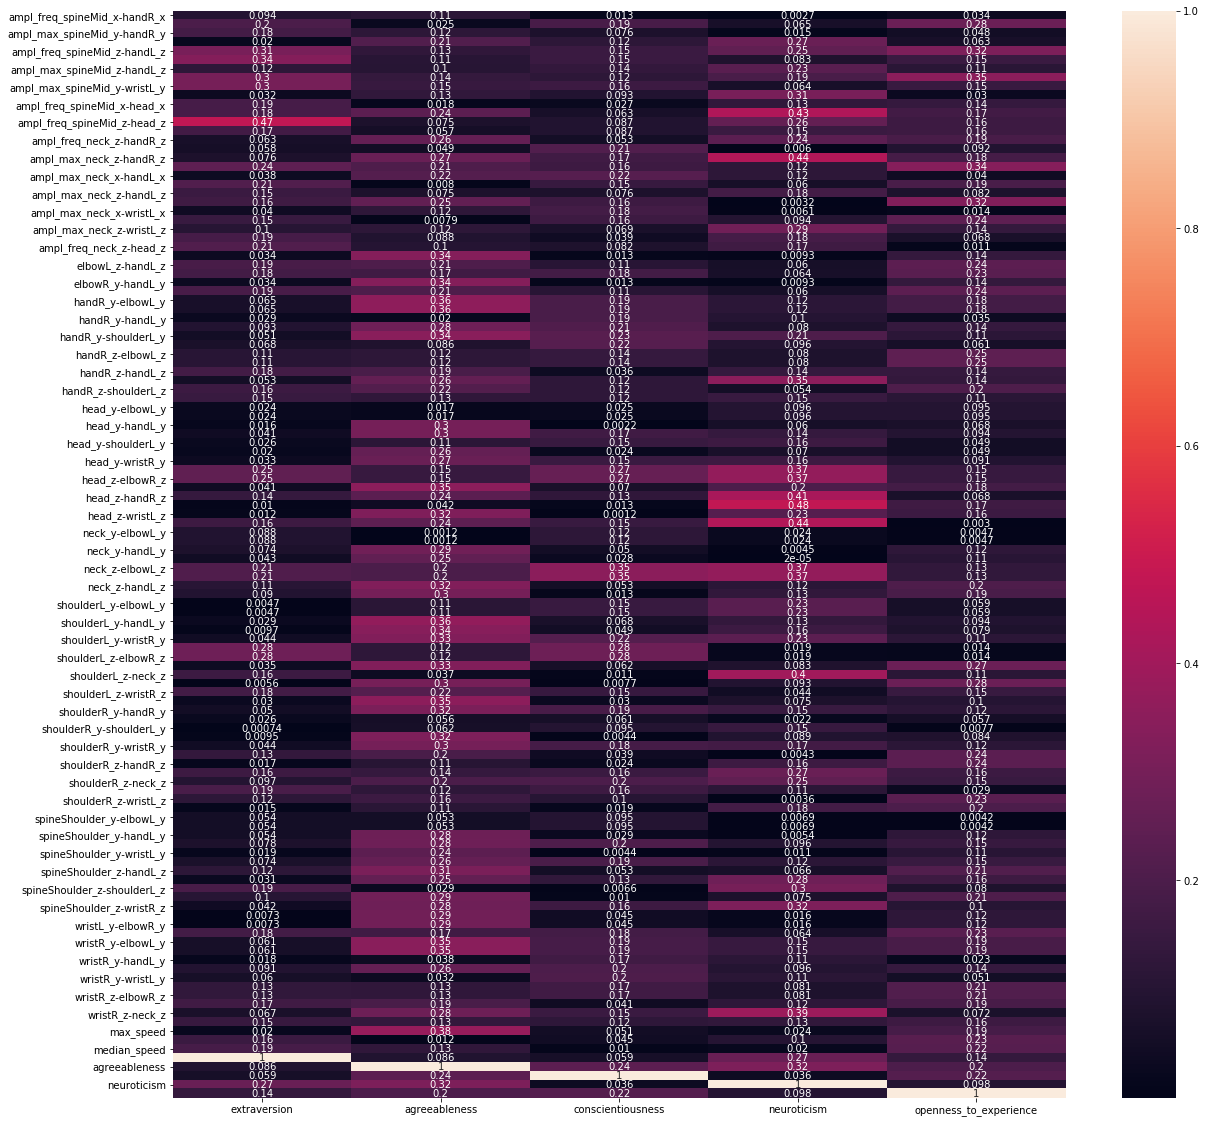

In [50]:
fig=plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(feat_pers_df.corr()[big5]), annot=True)

In [51]:
for trait in big5:
    print('Highest correlation for {0}'.format(trait))
    print(np.sort(feat_pers_df.corr()[trait])[-2])

Highest correlation for extraversion
0.473934998854
Highest correlation for agreeableness
0.357899155038
Highest correlation for conscientiousness
0.349405212013
Highest correlation for neuroticism
0.478046488986
Highest correlation for openness_to_experience
0.350250379633
